In [1]:
import numpy   as np
import pandas  as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing   import scale, StandardScaler
from sklearn.decomposition   import PCA, TruncatedSVD

import pickle

---

### Function Definition

In [2]:
def catPred(kmObj, gTrue, pred): 
    '''
        kmObjn: a kmeans object
        gTrue: true categories (ground truth)
    '''
    fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(50,12))

    numClusters = kmObj.get_params()['n_clusters']
    
    for i in range(numClusters):
        mask = (pred == i)
        val = np.unique( gTrue[mask], return_counts=True)
        lbl = val[0]
        ht  = val[1] / val[1].sum()
        ax[i].bar(range(numClusters), height=ht, tick_label = lbl)
        ax[i].set_xticklabels(lbl, fontsize=20)
        ax[i].set_title(i, fontsize=20)

        ax[0].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8"], fontsize=20)
        ax[0].set_ylabel("Proportion", fontsize = 32);
        plt.suptitle("Proportion of Categories in each Clusterc", fontsize = 32);

In [3]:
def top_pred_words(kmObj, X_df, ftrs_list, pred, num_reviews=5, num_words=5): 
    '''
        kmObjn: a kmeans object
        gTrue: true categories (ground truth)
    '''
    
    numClusters = kmObj.get_params()['n_clusters']
    
    for i in range(numClusters):
        mask = (pred == i)
        
        rev_ind = [ind for ind, flag in enumerate(mask) if flag]
        
        sample_reviews = np.random.choice(rev_ind, num_reviews, replace=False)
        
        print("\nCluster ", i, " =====")
        for review in sample_reviews:
            indx = X_df[review,:].indices
            data = X_df[review,:].data
            
            termsVals = indx[data.argsort()][-num_words:]
            
            terms = []
            for w in termsVals:
                terms.append(ftrs_list[w])
            print(terms)

---

### Large Pickled Dataset



In [4]:
df = pd.read_pickle("fiveCats.pkl")

In [5]:
X_df = df.drop('category', axis=1)
y_df = df['category']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [7]:
print( X_train.shape, X_test.shape)

(517403, 11) (221745, 11)


---

### Manipulate data sets

In [8]:
m_termTrans = pickle.load(open('pkl_tfidf.p','rb'))
m_scaler = pickle.load(open('pkl_scaler.p','rb'))
m_svd = pickle.load(open('pkl_svd.p','rb'))
m_kmeans = pickle.load(open('pkl_kmeans.p','rb'))

#### Vectorize Review Text

In [9]:
X_train_term  = m_termTrans.transform(X_train['text'])

In [10]:
X_train_term.shape

(517403, 153378)

In [11]:
ftrs = m_termTrans.get_feature_names()

#### Scale Sparse Matrix

In [12]:
m_scaler = pickle.load(open('pkl_scaler.p','rb'))

In [13]:
X_train_term = m_scaler.fit_transform(X_train_term)

In [14]:
# sklearn.preprocessing.MaxAbsScaler 
# it is okay to have large scales

#### Reduce Dimensionality

In [15]:
X_train_term_svd = m_svd.transform(X_train_term)

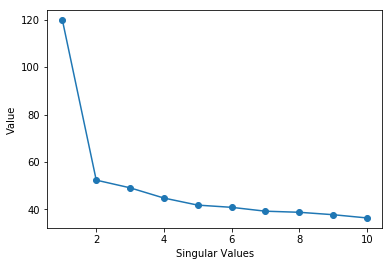

In [16]:
s = m_svd.singular_values_

x = [i+1 for i in range(len(s))]
plt.plot(x, s, marker='o')
plt.xlabel("Singular Values")
plt.ylabel("Value");

##### Percentage of Variance Explained

In [17]:
m_svd.explained_variance_ratio_.sum()*100

3.561945735071194

---

#### Cluster Reviews

In [18]:
X_test_term = m_termTrans.transform(X_test['text'])

In [19]:
X_test_term_scaled = m_scaler.transform(X_test_term)

In [20]:
X_test_term_svd = m_svd.transform(X_test_term_scaled)

In [21]:
X_test_term_svd.shape

(221745, 10)

In [22]:
pred = m_kmeans.predict(X_test_term_svd)

---

#### Visualize Clusters

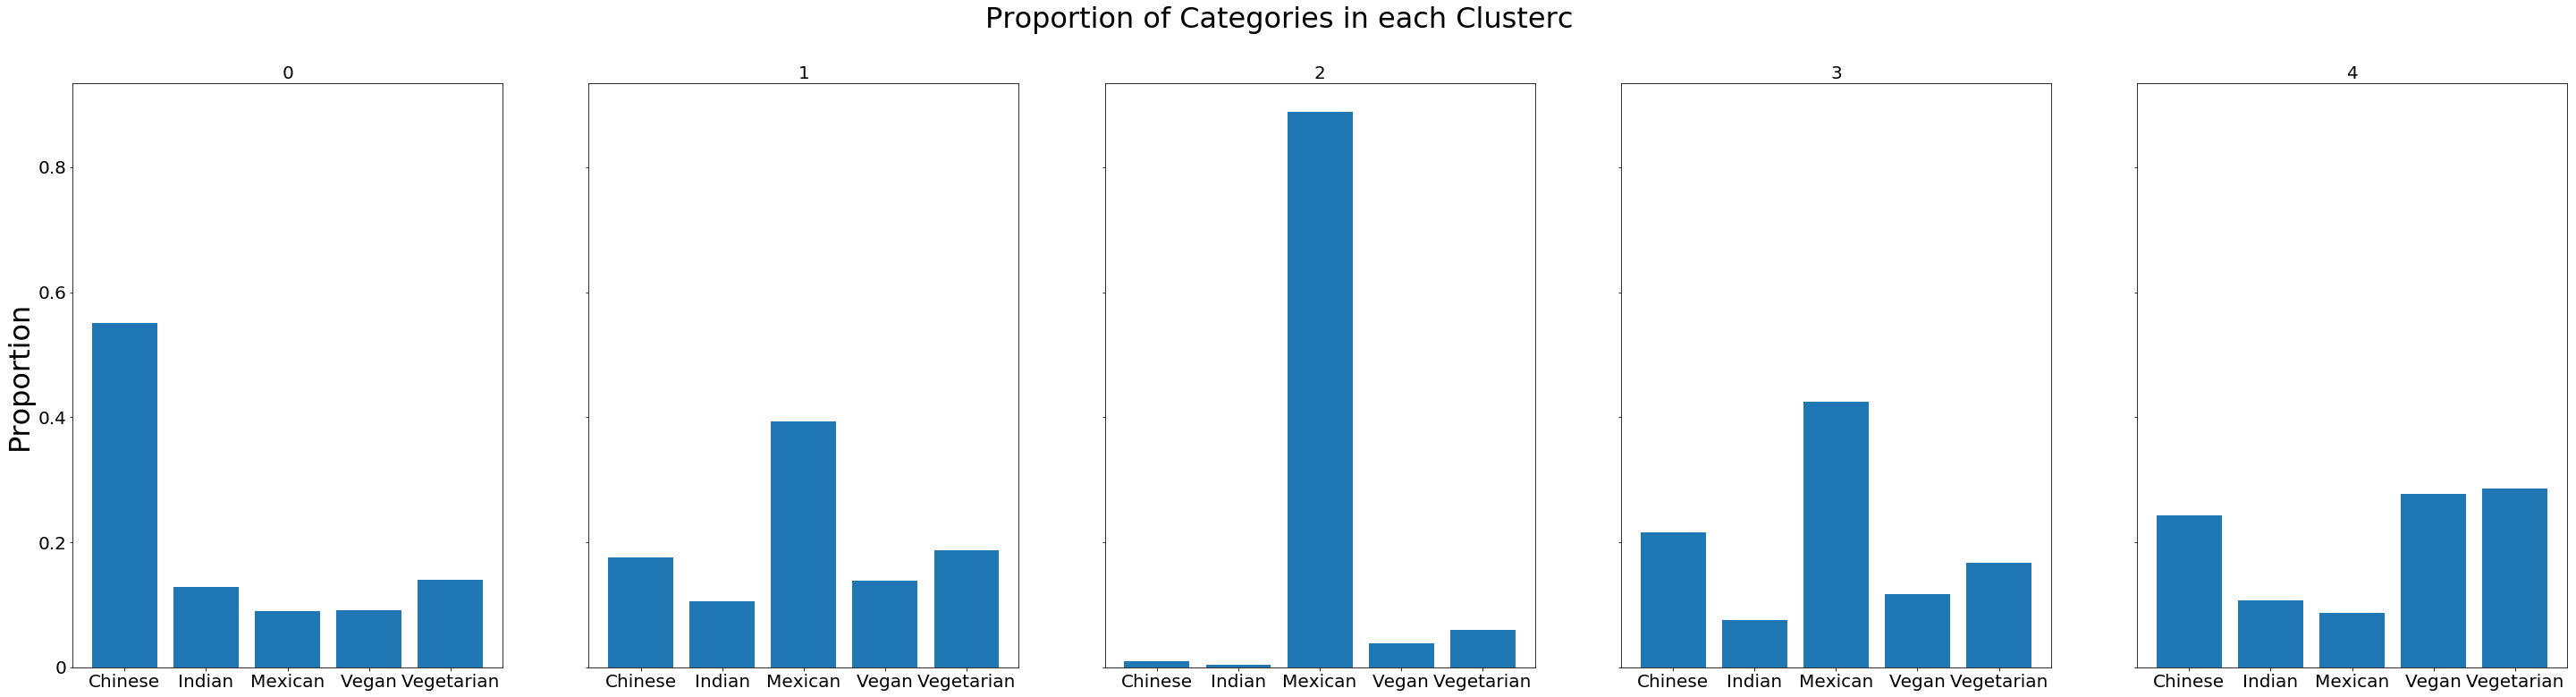

In [23]:
catPred(m_kmeans, y_test, pred)

In [24]:
top_pred_words(m_kmeans, X_test_term, ftrs, pred)


Cluster  0  =====
['diming', 'center', 'thai', 'lotus', 'dated']
['tailed', 'sayed', 'scallops', 'chicken', 'steamed']
['carrot', 'awesome', 'centre', 'bowl', 'eaton']
['magic', 'genius', 'andrew', 'devine', 'fran']
['love', 'veg', 'walnut', 'blow', 'brownie']

Cluster  1  =====
['sweet', 'burrito', 'clean', 'things', 'efficient']
['employees', 'corner', 'station', 'facility', 'hardworking']
['write', 'types', 'inexpensive', 'effort', 'clearance']
['picture', 'training', 'combined', 'tour', 'march']
['spiritually', 'reiki', 'practitioners', 'health', 'spirit']

Cluster  2  =====
['inject', 'nights', 'downtempo', 'tacos', 'hip']
['salsa', 'fried', 'avocado', 'deep', 'taco']
['overcooked', 'jicama', 'retained', 'astonishingly', 'cauliflower']
['tripa', 'tacos', 'las', 'el', 'gordo']
['fit', 'decent', 'broiled', 'mackerel', 'ambition']

Cluster  3  =====
['end', 'mariachis', 'strip', 'properties', 'getting']
['team', 'buffalonians', 'fries', 'steelers', 'paprikash']
['plate', 'garlic', '

#### Test Set: Class Balance

In [25]:
y_test.value_counts()

Mexican       90708
Chinese       58724
Vegetarian    31851
Vegan         21989
Indian        18473
Name: category, dtype: int64

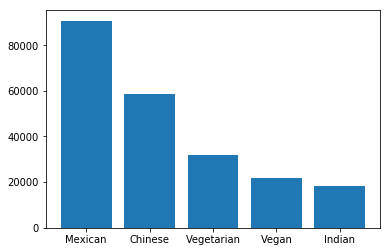

In [26]:
x = y_test.value_counts().values
lbls = list(y_test.value_counts().index)
plt.bar(range(len(x)), height=x, tick_label = lbls);

#### Train Set: Class Balance

In [27]:
y_train.value_counts()

Mexican       211169
Chinese       138298
Vegetarian     73939
Vegan          51464
Indian         42533
Name: category, dtype: int64

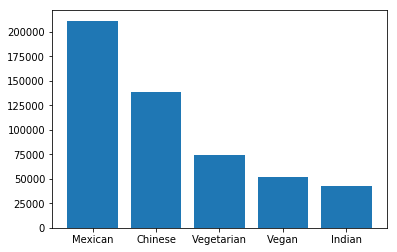

In [28]:
x = y_train.value_counts().values
lbls = list(y_train.value_counts().index)
plt.bar(range(len(x)), height=x, tick_label = lbls);

---

### Train data PREDICTION

In [29]:
pred2 = m_kmeans.predict(X_train_term_svd)

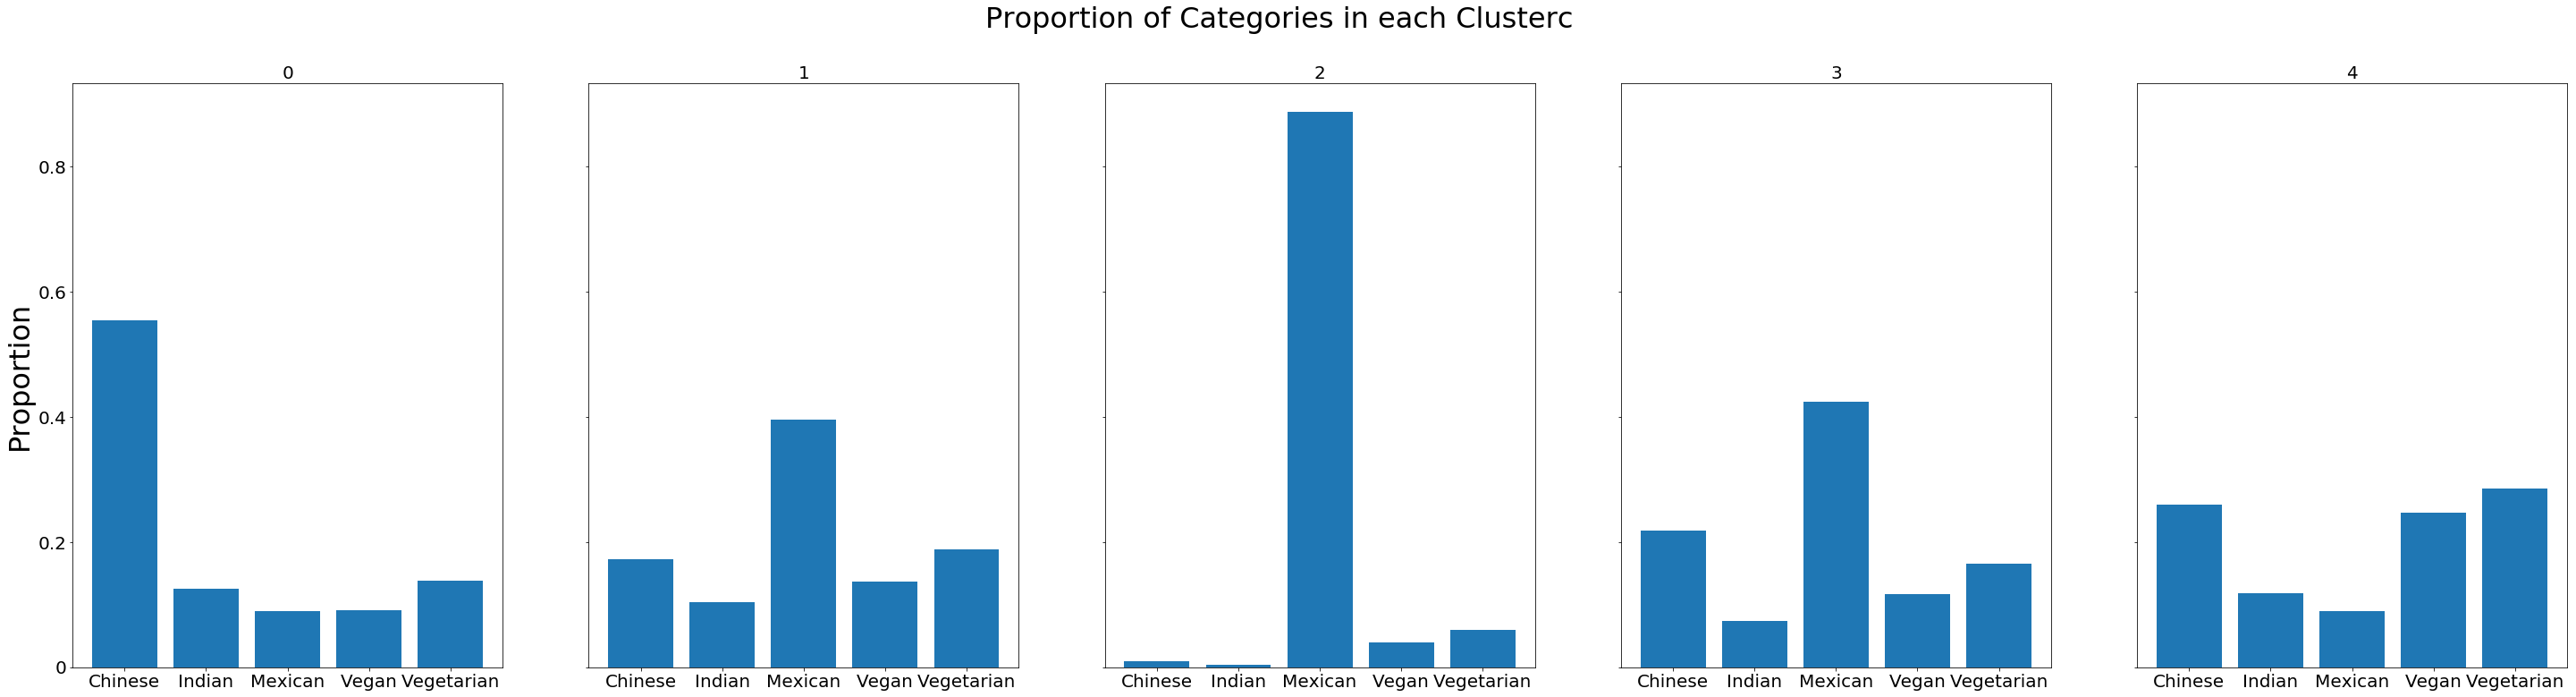

In [30]:
catPred(m_kmeans, y_train, pred2)

In [31]:
top_pred_words(m_kmeans, X_train_term, ftrs, pred2)


Cluster  0  =====
['greasy', 'perfectly', 'tom', 'rangoon', 'kha']
['imperial', 'wild', 'uneaten', 'maki', 'kamikazi']
['complementary', 'devoured', 'feedback', 'fiery', 'constructive']
['shell', 'preferred', 'pepper', 'vinegar', 'crabs']
['vegetables', 'generous', 'young', 'appears', 'foo']

Cluster  1  =====
['meal', 'dinner', 'authentic', 'clean', '14']
['locals', 'celebrate', 'anniversary', 'sweetheart', 'babe']
['extremely', 'fair', 'gotten', 'pleased', 'strongly']
['king', 'thank', 'haha', 'alex', 'scorpion']
['drive', 'twice', 'employees', 'normal', 'ect']

Cluster  2  =====
['chunky', 'snob', 'chimis', 'partial', 'ranked']
['salmon', 'diet', 'chopped', 'warning', 'dangerous']
['seriously', 'cause', 'swear', 'crack', 'sprinkle']
['church', 'cons', 'sweating', 'hooker', 'toooooooooooo']
['venture', 'isnt', 'adobado', '35th', 'biztec']

Cluster  3  =====
['improves', 'playhouse', 'viejo', 'puente', 'reckoned']
['forever', 'grease', 'post', 'swimming', 'scathing']
['compelled', 'p

# === === === === === === === === === === === === === === === 

In [32]:
# https://github.com/gSchool/dsi-solns-g69/blob/master/clustering/pair_part1_kmeans.py

In [33]:
pred

array([3, 3, 3, ..., 3, 0, 3], dtype=int32)

In [34]:
# Print out the reviews of a random sample of the restaurants assigned to each
# cluster to get a sense of the category.

print("\nRandom sample of reviews in each cluster")

assigned_cluster = m_kmeans.transform(X_train_term_svd)#.argmin(axis=1)


Random sample of reviews in each cluster


In [35]:
assigned_cluster

array([[10.70976395, 10.80950748, 10.80801317, 10.77709808, 10.82897384],
       [ 8.23425571,  8.23127872,  8.24559982,  8.17852668,  8.26335746],
       [10.1504984 , 10.20453895, 10.20683353, 10.20189912, 10.22653754],
       ...,
       [ 8.36048032,  8.45066269,  8.43484504,  8.42637785,  8.45482779],
       [ 7.48002472,  7.53974418,  7.53143227,  7.47844366,  7.52203524],
       [ 5.35965736,  5.36667635,  5.3447253 ,  5.33728206,  5.38497468]])

In [36]:
i = 1

assigned_cluster = m_kmeans.transform(X_train_term_svd)#.argmin(axis=1)

assigned_cluster = assigned_cluster[:10,:].argmin(axis=1)

assigned_cluster

array([0, 3, 0, 2, 1, 1, 3, 2, 1, 0])